In [1]:
import xarray as xr
#import gcsfs
#import intake
import numpy as np
import matplotlib
#import cmocean
import stats
import stats as st
from matplotlib import pyplot as plt
import ecco_v4_tools as ecco
%matplotlib inline

In [2]:
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.titlesize': 16})
matplotlib.rcParams.update({'figure.figsize': (10,8)})
matplotlib.rcParams.update({'lines.linewidth': 2})
matplotlib.rcParams.update({'legend.fontsize': 18})
matplotlib.rcParams.update({'mathtext.fontset': 'cm'})
matplotlib.rcParams.update({'ytick.major.size': 3})
matplotlib.rcParams.update({'axes.labelsize': 16})
matplotlib.rcParams.update({'ytick.labelsize': 16})
matplotlib.rcParams.update({'xtick.labelsize': 16})

## Load the data

The ECCOv4r3 data was converted from its raw MDS (.data / .meta file) format to zarr format, using the [xmitgcm](http://xmitgcm.readthedocs.io) package. [Zarr](http://zarr.readthedocs.io) is a powerful data storage format that can be thought of as an alternative to HDF. In contrast to HDF, zarr works very well with cloud object storage. Zarr is currently useable in python, java, C++, and julia. It is likely that zarr will form the basis of the next major version of the netCDF library.

If you're curious, here are some resources to learn more about zarr:
  - https://zarr.readthedocs.io/en/stable/tutorial.html
  - https://speakerdeck.com/rabernat/pangeo-zarr-cloud-data-storage
  - https://mrocklin.github.com/blog/work/2018/02/06/hdf-in-the-cloud

The ECCO zarr data currently lives in [Google Cloud Storage](https://cloud.google.com/storage/) as part of the [Pangeo Data Catalog](http://pangeo.io/catalog.html). This means we can open the whole dataset using one line of code.

This takes a bit of time to run because the metadata must be downloaded and parsed. The type of object returned is an [Xarray dataset](http://xarray.pydata.org/en/latest/data-structures.html#dataset).

In [3]:
cat = intake.open_catalog('catalog.yaml')
list(cat)

['sea_surface_height',
 'ECCOv4r3',
 'SOSE',
 'LLC4320_grid',
 'LLC4320_SST',
 'LLC4320_SSS',
 'LLC4320_SSH',
 'LLC4320_SSU',
 'LLC4320_SSV',
 'CESM_POP_hires_control',
 'CESM_POP_hires_RCP8_5',
 'GFDL_CM2_6_control_ocean_surface',
 'GFDL_CM2_6_control_ocean_3D',
 'GFDL_CM2_6_one_percent_ocean_surface',
 'GFDL_CM2_6_one_percent_ocean_3D',
 'GFDL_CM2_6_grid']

In [4]:
ds = cat.ECCOv4r3.to_dask()
ds

<xarray.Dataset>
Dimensions:    (face: 13, i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
    Depth      (face, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    PHrefC     (k) float32 dask.array<shape=(50,), chunksize=(50,)>
    PHrefF     (k_p1) float32 dask.array<shape=(51,), chunksize=(51,)>
    XC         (face, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    XG         (face, j_g, i_g) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    YC         (face, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    YG         (face, j_g, i_g) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    Z          (k) float32 dask.array<shape=(50,), chunksize=(50,)>
    Zl         (k_l) float32 dask.array<shape=(50,), chunksize=(50,)>
    Zp1        (k_p1) float32 dask.array<shape=(51,), chunksize=(51,)>
    Zu         (k_u) float32 dask.array<

In [5]:
ds.nbytes / 1e12

0.134190544604

In [6]:
# Load mixed layer depth from my Google cloud bucket 
ds_MXLDEPTH = xr.open_zarr(gcsfs.GCSMap('ecco-data/MXLDEPTH'))

Note that no data has been actually download yet. Xarray uses the approach of _lazy evaluation_, in which loading of data and execution of computations is delayed as long as possible (i.e. until data is actually needed for a plot). The data are represented symbolically as [dask arrays](http://docs.dask.org/en/latest/array.html). For example:

    SALT       (time, k, face, j, i) float32 dask.array<shape=(288, 50, 13, 90, 90), chunksize=(1, 50, 13, 90, 90)>
    
The full shape of the array is (288, 50, 13, 90, 90), quite large. But the _chunksize_ is (1, 50, 13, 90, 90). Here the chunks correspond to the individual granuales of data (objects) in cloud storage. The chunk is the minimum amount of data we can read at one time.

In [7]:
# a trick to make things work a bit faster
coords = ds.coords.to_dataset().reset_coords()
ds = ds.reset_coords(drop=True)

## Visualizing Data

### A Direct Plot

Let's try to visualize something simple: the `Depth` variable. Here is how the data are stored:

    Depth      (face, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>

Although depth is a 2D field, there is an extra, dimension (`face`) corresponding to the LLC face number. Let's use xarray's built in plotting functions to plot each face individually.

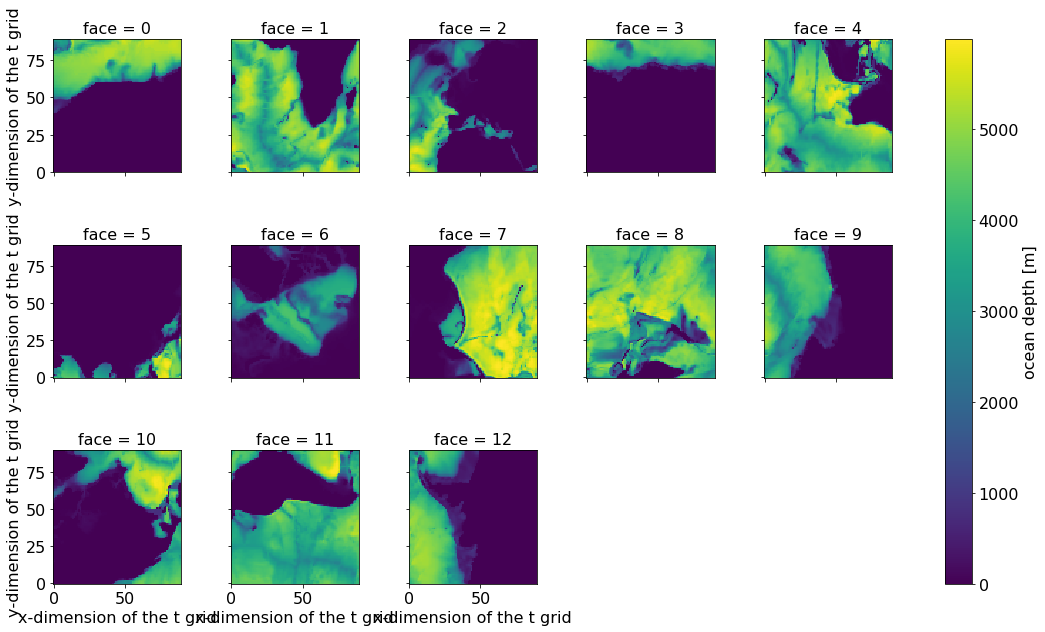

In [8]:
coords.Depth.plot(col='face', col_wrap=5)

This view is not the most useful. It reflects how the data is arranged logically, rather than geographically.

### A Pretty Map

To make plotting easier, I have created a simple module (`llcmapping.py`, try opening it and looking at the code) that does one thing: regrid the LLC data and plot it on a lat-lon map.

(<cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7fdd68160ac8>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7fdd68160ac8>)

<Figure size 864x720 with 0 Axes>

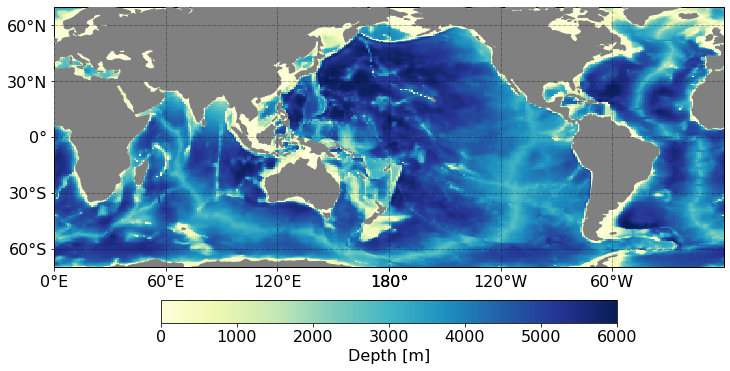

In [9]:
import importlib
import llcmapping
importlib.reload(llcmapping)
from llcmapping import LLCMapper
#facen=[0,1,2,3,4,5,6,7,8,9,10,11,12]
mapper = LLCMapper(coords)
lons = coords.XC
lats = coords.YC
bnds = [0,359.9,-70,70]
plt.figure(figsize=(12,10))
mapper(coords.Depth, bnds=bnds, cmap='YlGnBu', vmax=6000,vmin=0)

In [10]:
mxldepth = ds_MXLDEPTH.MXLDEPTH
mxldepth.coords['i'] = coords['i']
mxldepth.coords['j'] = coords['j']
mxldepth

<xarray.DataArray 'MXLDEPTH' (face: 13, time: 288, j: 90, i: 90)>
dask.array<shape=(13, 288, 90, 90), dtype=float64, chunksize=(1, 288, 90, 90)>
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
    lat      (face, j, i) float64 dask.array<shape=(13, 90, 90), chunksize=(1, 90, 90)>
    lon      (face, j, i) float64 dask.array<shape=(13, 90, 90), chunksize=(1, 90, 90)>
    tim      (time) datetime64[ns] dask.array<shape=(288,), chunksize=(288,)>
  * time     (time) float64 1.0 2.0 3.0 4.0 5.0 ... 285.0 286.0 287.0 288.0
Dimensions without coordinates: face
Attributes:
    long_name:  Mixed-Layer Depth (>0)
    units:      m

In [11]:
# Calculate mean mixed layer depth
mxldepth_clim=mxldepth.mean(dim='time').load()

(<cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7fdd680232b0>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7fdd680232b0>)

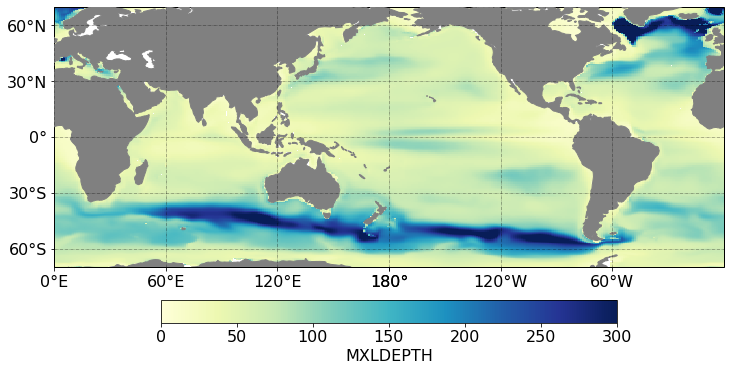

In [12]:
# Plot mean mixed layer depth
mapper(mxldepth_clim, bnds=bnds, cmap='YlGnBu', vmax=300,vmin=0)

We can use this with any 2D cell-centered LLC variable.

## Selecting data

The entire ECCOv4e3 dataset is contained in a single `Xarray.Dataset` object. How do we find a view specific pieces of data? This is handled by Xarray's [indexing and selecting functions](http://xarray.pydata.org/en/latest/indexing.html). To get the SST from January 2000, we do this:

In [13]:
sst = ds.THETA.sel(time='2000-01-15', k=0)
sst

<xarray.DataArray 'THETA' (face: 13, j: 90, i: 90)>
dask.array<shape=(13, 90, 90), dtype=float32, chunksize=(13, 90, 90)>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
    k        int64 0
    time     datetime64[ns] 2000-01-15
Attributes:
    long_name:      Potential Temperature
    standard_name:  THETA
    units:          degC

Still no data has been actually downloaded. That doesn't happen until we call `.load()` explicitly or try to make a plot.

## Speeding things up with a Dask Cluster

How can we speed things up? In general, the main bottleneck for this type of data analysis is the speed with which we can read the data. With cloud storage, the access is highly parallelizeable.

From a Pangeo environment, we can create a [Dask cluster](https://distributed.dask.org/en/latest/) to spread the work out amongst many compute nodes. This works on both HPC and cloud. In the cloud, the compute nodes are provisioned on the fly and can be shut down as soon as we are done with our analysis.

The code below will create a cluster with five compute nodes, each with 20GB of RAM.

In [14]:
#from dask.distributed import Client, progress
#from dask_kubernetes import KubeCluster
#cluster = KubeCluster(n_workers=20)
#cluster

In [15]:
#client = Client(cluster)
#client

Now we re-run the mean calculation. Note how the dashboard at right helps us visualize what the cluster is doing.

In [16]:
%time ds.THETA.isel(k=0).mean(dim='time').load()

CPU times: user 1min, sys: 40.6 s, total: 1min 41s
Wall time: 54 s


<xarray.DataArray 'THETA' (face: 13, j: 90, i: 90)>
array([[[ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        ...,
        [ 0.432548,  0.420362, ...,  0.243915,  0.291386],
        [ 0.653515,  0.658455, ...,  0.427649,  0.498188]],

       [[ 0.872101,  0.891548, ...,  0.602339,  0.697784],
        [ 1.096168,  1.117599, ...,  0.774091,  0.891288],
        ...,
        [27.589699, 27.559296, ..., 26.44383 , 26.62003 ],
        [27.37777 , 27.343906, ...,  0.      , 26.430416]],

       ...,

       [[27.479862, 27.624815, ...,  5.60189 ,  5.157408],
        [27.488213, 27.622663, ...,  5.657171,  5.213162],
        ...,
        [27.444382, 27.641308, ...,  1.204041,  1.031747],
        [27.411293, 27.615599, ...,  1.113161,  0.912151]],

       [[ 4.696424,  4.21946 , ...,  0.      ,  0.      ],
        [ 4.747999,  4.27007 , ...,  0.      ,  0.      ],
        ...,
        [ 0.851896,  0.651258, ...,  0.      ,  0. 

## Spatially-Integrated Heat Content Anomaly

Now let's do something harder. We will calculate the horizontally integrated heat content anomaly for the full 3D model domain.

In [17]:
# the monthly climatology
theta_clim = ds.THETA.groupby('time.month').mean(dim='time')
# the anomaly
theta_anom = ds.THETA.groupby('time.month') - theta_clim
rho0 = 1029
cp = 3994
ohc = rho0 * cp * (theta_anom *
                   coords.rA *
                   coords.hFacC).sum(dim=['face', 'j', 'i'])
ohc

<xarray.DataArray (time: 288, k: 50)>
dask.array<shape=(288, 50), dtype=float64, chunksize=(1, 50)>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

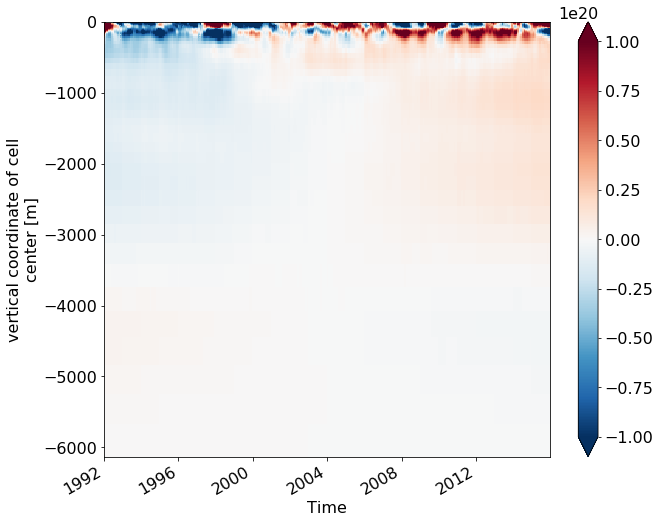

In [18]:
# actually load the data
ohc.load()
# put the depth coordinate back for plotting purposes
ohc.coords['Z'] = coords.Z
ohc.swap_dims({'k': 'Z'}).transpose().plot(cmap='RdBu_r', vmax=1e20)

## Spatial Derivatives: Heat Budget

As our final exercise, we will do something much more complicated. We will compute the time-mean convergence of vertically-integrated heat fluxes. This is hard for several reasons.

The first reason it is hard is because it involves variables located at different grid points.
Following MITgcm conventions, xmitgcm (which produced this dataset) labels the center point with the coordinates `j, i`, the u-velocity point as `j, i_g`, and the v-velocity point as `j_g, i`. 
The horizontal advective heat flux variables are

    ADVx_TH    (time, k, face, j, i_g) float32 dask.array<shape=(288, 50, 13, 90, 90), chunksize=(1, 50, 13, 90, 90)>
    ADVy_TH    (time, k, face, j_g, i) float32 dask.array<shape=(288, 50, 13, 90, 90), chunksize=(1, 50, 13, 90, 90)>
    
Xarray won't allow us to add or multiply variables that have different dimensions, and xarray by itself doesn't understand how to transform from one grid position to another.

**That's why [xgcm](https://xgcm.readthedocs.io/en/latest/) was created.**

Xgcm allows us to create a `Grid` object, which understands how to interpolate and take differences in a way that is compatible with finite volume models such at MITgcm. Xgcm also works with many other models, including ROMS, POP, MOM5/6, NEMO, etc.

A second reason this is hard is because of the complex topology connecting the different MITgcm faces. Fortunately xgcm also [supports this](https://xgcm.readthedocs.io/en/latest/grid_topology.html).

In [19]:
import xgcm

# define the connectivity between faces
face_connections = {'face':
                    {0: {'X':  ((12, 'Y', False), (3, 'X', False)),
                         'Y':  (None,             (1, 'Y', False))},
                     1: {'X':  ((11, 'Y', False), (4, 'X', False)),
                         'Y':  ((0, 'Y', False),  (2, 'Y', False))},
                     2: {'X':  ((10, 'Y', False), (5, 'X', False)),
                         'Y':  ((1, 'Y', False),  (6, 'X', False))},
                     3: {'X':  ((0, 'X', False),  (9, 'Y', False)),
                         'Y':  (None,             (4, 'Y', False))},
                     4: {'X':  ((1, 'X', False),  (8, 'Y', False)),
                         'Y':  ((3, 'Y', False),  (5, 'Y', False))},
                     5: {'X':  ((2, 'X', False),  (7, 'Y', False)),
                         'Y':  ((4, 'Y', False),  (6, 'Y', False))},
                     6: {'X':  ((2, 'Y', False),  (7, 'X', False)),
                         'Y':  ((5, 'Y', False),  (10, 'X', False))},
                     7: {'X':  ((6, 'X', False),  (8, 'X', False)),
                         'Y':  ((5, 'X', False),  (10, 'Y', False))},
                     8: {'X':  ((7, 'X', False),  (9, 'X', False)),
                         'Y':  ((4, 'X', False),  (11, 'Y', False))},
                     9: {'X':  ((8, 'X', False),  None),
                         'Y':  ((3, 'X', False),  (12, 'Y', False))},
                     10: {'X': ((6, 'Y', False),  (11, 'X', False)),
                          'Y': ((7, 'Y', False),  (2, 'X', False))},
                     11: {'X': ((10, 'X', False), (12, 'X', False)),
                          'Y': ((8, 'Y', False),  (1, 'X', False))},
                     12: {'X': ((11, 'X', False), None),
                          'Y': ((9, 'Y', False),  (0, 'X', False))}}}

# create the grid object
grid = xgcm.Grid(ds, periodic=False, face_connections=face_connections)
grid

<xgcm.Grid>
Y Axis (not periodic):
  * center   j --> left
  * left     j_g --> center
X Axis (not periodic):
  * center   i --> left
  * left     i_g --> center
T Axis (not periodic):
  * center   time --> inner
  * inner    time_snp --> center
Z Axis (not periodic):
  * center   k --> left
  * left     k_l --> center
  * outer    k_p1 --> center
  * right    k_u --> center

Now we can use the `grid` object we created to take the divergence of a 2D vector

In [20]:
# vertical integral and time mean of horizontal advective heat flux
advx_th_vint = ds.ADVx_TH.sum(dim='k').mean(dim='time')
advy_th_vint = ds.ADVy_TH.sum(dim='k').mean(dim='time')

# difference in the x and y directions
diff_ADV_th = grid.diff_2d_vector({'X': advx_th_vint, 'Y': advy_th_vint}, boundary='fill')
# convergence
conv_ADV_th = -diff_ADV_th['X'] - diff_ADV_th['Y']
conv_ADV_th

<xarray.DataArray (face: 13, j: 90, i: 90)>
dask.array<shape=(13, 90, 90), dtype=float32, chunksize=(1, 89, 89)>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89

In [21]:
# vertical integral and time mean of horizontal diffusive heat flux
difx_th_vint = ds.DFxE_TH.sum(dim='k').mean(dim='time')
dify_th_vint = ds.DFyE_TH.sum(dim='k').mean(dim='time')

# difference in the x and y directions
diff_DIF_th = grid.diff_2d_vector({'X': difx_th_vint, 'Y': dify_th_vint}, boundary='fill')
# convergence
conv_DIF_th = -diff_DIF_th['X'] - diff_DIF_th['Y']
conv_DIF_th

<xarray.DataArray (face: 13, j: 90, i: 90)>
dask.array<shape=(13, 90, 90), dtype=float32, chunksize=(1, 89, 89)>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89

In [22]:
# convert to Watts / m^2 and load
mean_adv_conv = rho0 * cp * (conv_ADV_th/coords.rA).fillna(0.).load()
mean_dif_conv = rho0 * cp * (conv_DIF_th/coords.rA).fillna(0.).load()

In [23]:
# Standard Deviation of SST
sst_anom = theta_anom.isel(k=0)
sst_std = sst_anom.std(dim='time').load()

In [24]:
# Standard Deviation of Surface heat flux
Qs_clim = ds.TFLUX.groupby('time.month').mean(dim='time')
Qs_anom = ds.TFLUX.groupby('time.month') - Qs_clim
Qs_std = Qs_anom.std(dim='time').load()

In [25]:
# Vertical integral of ocean heat transport over ocean mixed layer
ADVx_TH_clim = ds.ADVx_TH.groupby('time.month').mean(dim='time')
ADVx_TH_anom = ds.ADVx_TH.groupby('time.month') - ADVx_TH_clim

ADVy_TH_clim = ds.ADVy_TH.groupby('time.month').mean(dim='time')
ADVy_TH_anom = ds.ADVy_TH.groupby('time.month') - ADVy_TH_clim

delz = coords.drF*coords.hFacC
v = coords.rA*coords.drF*coords.hFacC

#ADVx_TH_anom = ADVx_TH_anom.where(mxlpoints)
#ADVy_TH_anom = ADVy_TH_anom.where(mxlpoints)

#ADVx_TH_anom_vint = ADVx_TH_anom.sum(dim='k')
#ADVy_TH_anom_vint = ADVy_TH_anom.sum(dim='k')

#delz = coords.drF*coords.hFacC
delz = coords.drF*coords.hFacC

#ADV_TH_diff_anom_vint = grid.diff_2d_vector({'X': ADVx_TH_anom_vint, 'Y': ADVy_TH_anom_vint}, boundary='fill')

ADV_TH_diff_anom = grid.diff_2d_vector({'X': ADVx_TH_anom, 'Y': ADVy_TH_anom}, boundary='fill')

ADV_TH_conv_anom_vint = -((delz/v)*ADV_TH_diff_anom['X']).sum(dim='k') - ((delz/v)*ADV_TH_diff_anom['Y']).sum(dim='k')

ADV_TH_std = ADV_TH_conv_anom_vint.std(dim='time')

ADV_TH_std = rho0 * cp * ADV_TH_std.fillna(0.).load()

In [26]:
#Calculate standard deviation of vertically-integrated ocean diffusive heat convergence
DFxE_TH_clim = ds.DFxE_TH.groupby('time.month').mean(dim='time')
DFxE_TH_anom = ds.DFxE_TH.groupby('time.month') - DFxE_TH_clim

DFyE_TH_clim = ds.DFyE_TH.groupby('time.month').mean(dim='time')
DFyE_TH_anom = ds.DFyE_TH.groupby('time.month') - DFyE_TH_clim

#DFxE_TH_anom_vint = DFxE_TH_anom.sum(dim='k')
#DFyE_TH_anom_vint = DFyE_TH_anom.sum(dim='k')

DF_TH_diff_anom = grid.diff_2d_vector({'X': DFxE_TH_anom, 'Y': DFyE_TH_anom}, boundary='fill')

DF_TH_conv_anom_vint = -((delz/v)*DF_TH_diff_anom['X']).sum(dim='k')-((delz/v)*DF_TH_diff_anom['Y']).sum(dim='k')

DF_TH_std = DF_TH_conv_anom_vint.std(dim='time').load()

DF_TH_std = rho0 * cp * DF_TH_std.fillna(0.).load()


KeyboardInterrupt: 

In [ ]:
m, ax = mapper(sst_std**2, bnds=bnds, cmap='cubehelix_r', vmax=1.6, vmin=0);
ax.set_title(r'SST Variance (K$^2$)');

In [ ]:
m, ax = mapper(mean_adv_conv, bnds=bnds, cmap='RdBu_r', vmax=200, vmin=-200);
ax.set_title(r'Convergence of Advective Flux (W/m$^2$)');

In [ ]:
m, ax = mapper(mean_dif_conv,  bnds=bnds, cmap='RdBu_r', vmax=200, vmin=-200)
ax.set_title(r'Convergence of Diffusive Flux (W/m$^2$)');

In [ ]:
m, ax = mapper(mean_dif_conv + mean_adv_conv,  bnds=bnds, cmap='RdBu_r', vmax=200, vmin=-200)
ax.set_title(r'Convergence of Net Horizontal Flux (W/m$^2$)');

In [ ]:
# Plot standard deviation of vertically-integrated ocean heat convergence
m, ax = mapper(ADV_TH_std,  bnds=bnds, cmap='cubehelix_r', vmax=300, vmin=0);
ax.set_title(r'Standard Deviation of Vertically-Integrated Ocean Heat Convergence (W/m$^2$)');

In [ ]:
# Standard deviation of surface heat flux
m, ax = mapper(Qs_std,  bnds=bnds, cmap='cubehelix_r', vmax=60, vmin=0);
ax.set_title(r'Standard Deviation of Surface Heat Flux (W/m$^2$)');

In [ ]:
# Standard deviation of vertically-integrated ocean diffusive heat convergence
m, ax = mapper(DF_TH_std,  bnds=bnds, cmap='cubehelix_r', vmax=60, vmin=0);
ax.set_title(r'Standard Deviation of Vertically-Integrated Ocean Diffusive Heat Convergence (W/m$^2$)')

In [ ]:
# Test detrending
# import xscale
# from xscale.xscale.signal.fitting import detrend, linreg
import scipy.signal as signal

In [ ]:
# Mask 0 entries (continents)
theta_anom = theta_anom.where(theta_anom != 0)
landmask = theta_anom == np.nan
landmask

In [ ]:
#Plot global mean time series (not detrended)
areas = coords['rA']
globearea = areas.sum()
weights = areas/globearea
sst_anom = theta_anom.isel(k=0)
sst_globmean = (weights*sst_anom).sum(dim=('face','i','j')).load()
#sst_base = sst_anom.sel(time=slice('1992-01-15','2000-01-15'))
#sst_globmean_base = (weights*sst_base).sum().load()
#sst_globmean_base #Why is this zero? FIX.

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(sst_anom.time, sst_globmean)
plt.axhline(0,color='k',linewidth=1)

In [ ]:
# Detrend SST
#test = detrend(test, dim='time', type='linear')
#test.dims
sst_anom = sst_anom.fillna(0.)
sst_anom = xr.DataArray(signal.detrend(sst_anom, axis=0), dims=sst_anom.dims, coords=sst_anom.coords)

In [ ]:
#Rechunk after detrending
sst_anom.chunk({'time':1})
sst_anom = sst_anom.where(sst_anom != 0)

In [ ]:
sst_globmean_detr = sst_anom.mean(dim=('face','i','j')).load()
plt.figure(figsize=(12,6))
plt.plot(sst_anom.time, sst_globmean, label='original')
plt.plot(sst_anom.time, sst_globmean_detr, label='detrended')
plt.legend()

In [ ]:
sst_std = sst_anom.std(dim='time')

In [ ]:
m, ax = mapper(sst_std,  bnds=bnds, cmap='cubehelix_r', vmax=1.3, vmin=0);
ax.set_title(r'Standard Deviation of Detrended SST (C$^{\circ}$)');

In [ ]:
Qs_anom = xr.DataArray(signal.detrend(Qs_anom, axis=0), dims=Qs_anom.dims, coords=Qs_anom.coords)

In [ ]:
#Rechunk after detrending
Qs_anom.chunk({'time':1})

In [ ]:
Qs_std_detr = Qs_anom.std(dim='time').load()

In [ ]:
# Standard deviation of surface heat flux
m, ax = mapper(Qs_std_detr,  bnds=bnds, cmap='cubehelix_r', vmax=60, vmin=0);
ax.set_title(r'Standard Deviation of Detrended Surface Heat Flux (W/m$^2$)');

In [ ]:
# Test subsetting ocean mixed layer points
mxlpoints = np.abs(coords['Z']) <= mxldepth_clim

In [ ]:
#delz = coords.drF*coords.hFacC
delz = coords.drF*coords.hFacC

In [ ]:
delz=delz.where(mxlpoints)
delz_sum = delz.sum(dim='k')

In [ ]:
mxl_theta = theta_anom.where(mxlpoints)
mxl_theta

In [ ]:
weights = delz/delz_sum

In [ ]:
#mxl_theta_mean = mxl_theta.mean(dim='k', skipna=True)
mxl_theta_mean = (mxl_theta*weights).sum(dim='k')
mxl_theta_mean

In [ ]:
mxl_theta_std = mxl_theta_mean.std(dim='time').load()

In [ ]:
m, ax = mapper(mxl_theta_std,  bnds=bnds, cmap='cubehelix_r', vmax=1.3, vmin=0);
ax.set_title(r'Variance of Mean Mixed Layer Temperature (C$^{\circ}$)');

In [ ]:
m, ax = mapper(sst_std,  bnds=bnds, cmap='cubehelix_r', vmax=1.3, vmin=0);
ax.set_title(r' SST (C$^{\circ}$)');

In [ ]:
# Mixed layer vertical integral of time-averaged vertical heat transport
v = coords.rA*coords.drF*coords.hFacC
delz = coords.drF*coords.hFacC
ADVr_TH_clim = ds.ADVr_TH.mean(dim='time')
ADVr_TH_diff_clim = grid.diff(ADVr_TH_clim, 'Z', boundary='extend')
ADVr_TH_clim_vint = ((delz/v)*ADVr_TH_diff_clim).where(mxlpoints).sum(dim='k')

ADVr_TH_mean = rho0 * cp * ADVr_TH_clim_vint.fillna(0.).load()

In [ ]:
# Mixed layer vertical integral of time-averaged horizontal heat transport
ADVx_TH_clim = ds.ADVx_TH.mean(dim='time')
ADVy_TH_clim = ds.ADVy_TH.mean(dim='time')
ADV_TH_diff_clim = grid.diff_2d_vector({'X': ADVx_TH_clim, 'Y': ADVy_TH_clim}, boundary='fill')
ADV_TH_conv_clim_vint = -((delz/v)*ADV_TH_diff_clim['X']).where(mxlpoints).sum(dim='k') - ((delz/v)*ADV_TH_diff_clim['Y']).where(mxlpoints).sum(dim='k')
ADV_TH_mean = rho0 * cp * ADV_TH_conv_clim_vint.fillna(0.).load()

In [ ]:
# Same as previous except for horizontal diffusion 
DFxE_TH_clim = ds.DFxE_TH.mean(dim='time')
DFyE_TH_clim = ds.DFyE_TH.mean(dim='time')
DF_TH_diff_clim = grid.diff_2d_vector({'X': DFxE_TH_clim, 'Y': DFyE_TH_clim}, boundary='fill')
DF_TH_conv_clim_vint = -((delz/v)*DF_TH_diff_clim['X']).where(mxlpoints).sum(dim='k') - ((delz/v)*DF_TH_diff_clim['Y']).where(mxlpoints).sum(dim='k')
DF_TH_mean = rho0 * cp * DF_TH_conv_clim_vint.fillna(0.).load()



In [ ]:
# Same as previous except for vertical diffusion (explicit and implicit)
DFrE_TH_clim = ds.DFrE_TH.mean(dim='time')
DFrI_TH_clim = ds.DFrI_TH.mean(dim='time')
DFrE_TH_diff_clim = grid.diff(DFrE_TH_clim, 'Z', boundary='extend')
DFrI_TH_diff_clim = grid.diff(DFrI_TH_clim, 'Z', boundary='extend')

DFrE_TH_clim_vint = ((delz/v)*DFrE_TH_diff_clim).where(mxlpoints).sum(dim='k')
DFrI_TH_clim_vint = ((delz/v)*DFrI_TH_diff_clim).where(mxlpoints).sum(dim='k')

DFr_TH_clim_vint = DFrE_TH_clim_vint + DFrI_TH_clim_vint

DFr_TH_mean = rho0 * cp * DFr_TH_clim_vint.fillna(0.).load()

In [ ]:
# Mixed layer vertical integral of ocean heat transport 
ADVx_TH_clim = ds.ADVx_TH.groupby('time.month').mean(dim='time')
ADVx_TH_anom = ds.ADVx_TH.groupby('time.month') - ADVx_TH_clim

ADVy_TH_clim = ds.ADVy_TH.groupby('time.month').mean(dim='time')
ADVy_TH_anom = ds.ADVy_TH.groupby('time.month') - ADVy_TH_clim

ADV_TH_diff_anom = grid.diff_2d_vector({'X': ADVx_TH_anom, 'Y': ADVy_TH_anom}, boundary='fill')

ADV_TH_conv_anom_vint = -((delz/v)*ADV_TH_diff_anom['X']).where(mxlpoints).sum(dim='k') - ((delz/v)*ADV_TH_diff_anom['Y']).where(mxlpoints).sum(dim='k')

ADV_TH_std = ADV_TH_conv_anom_vint.std(dim='time')

ADV_TH_std = rho0 * cp * ADV_TH_std.fillna(0.).load()

In [ ]:
# Mixed layer vertical integral of vertical ocean heat convergence 
ADVr_TH_clim = ds.ADVr_TH.groupby('time.month').mean(dim='time')
ADVr_TH_anom = ds.ADVr_TH.groupby('time.month') - ADVr_TH_clim

ADVr_TH_diff_anom = grid.diff(ADVr_TH_anom, 'Z', boundary='extend')

ADVr_TH_conv_anom_vint = ((delz/v)*ADVr_TH_diff_anom).where(mxlpoints).sum(dim='k')

ADVr_TH_std = ADVr_TH_conv_anom_vint.std(dim='time')

ADVr_TH_std = rho0 * cp * ADVr_TH_std.fillna(0.).load()

In [ ]:
# Same as previous except for diffusive terms
DFxE_TH_clim = ds.DFxE_TH.groupby('time.month').mean(dim='time')
DFxE_TH_anom = ds.DFxE_TH.groupby('time.month') - DFxE_TH_clim

DFyE_TH_clim = ds.DFyE_TH.groupby('time.month').mean(dim='time')
DFyE_TH_anom = ds.DFyE_TH.groupby('time.month') - DFyE_TH_clim

DF_TH_diff_anom = grid.diff_2d_vector({'X': DFxE_TH_anom, 'Y': DFyE_TH_anom}, boundary='fill')

DF_TH_conv_anom_vint = -((delz/v)*DF_TH_diff_anom['X']).where(mxlpoints).sum(dim='k') - ((delz/v)*DF_TH_diff_anom['Y']).where(mxlpoints).sum(dim='k')

DF_TH_std = DF_TH_conv_anom_vint.std(dim='time')

DF_TH_std = rho0 * cp * DF_TH_std.fillna(0.).load()

In [ ]:
DFrE_TH_clim = ds.DFrE_TH.groupby('time.month').mean(dim='time')
DFrE_TH_anom = ds.DFrE_TH.groupby('time.month') - DFrE_TH_clim

DFrI_TH_clim = ds.DFrI_TH.groupby('time.month').mean(dim='time')
DFrI_TH_anom = ds.DFrI_TH.groupby('time.month') - DFrI_TH_clim

DFrE_TH_diff_anom = grid.diff(DFrE_TH_anom, 'Z', boundary='extend')
DFrI_TH_diff_anom = grid.diff(DFrI_TH_anom, 'Z', boundary='extend')

DFrE_TH_conv_anom_vint = ((delz/v)*DFrE_TH_diff_anom).where(mxlpoints).sum(dim='k')
DFrI_TH_conv_anom_vint = ((delz/v)*DFrI_TH_diff_anom).where(mxlpoints).sum(dim='k')

DFr_TH_conv_anom_vint = DFrE_TH_conv_anom_vint + DFrI_TH_conv_anom_vint

DFr_TH_std = DFr_TH_conv_anom_vint.std(dim='time')

DFr_TH_std = rho0 * cp * DFr_TH_std.fillna(0.).load()


In [ ]:
# Time-averaged vertical heat convergence in ocean mixed layer
m, ax = mapper(ADVr_TH_mean,  bnds=bnds, cmap='RdBu_r', vmax=500, vmin=-500);
ax.set_title(r'Time-averaged Vertical Heat Convergence in Mixed Layer (W/m$^2$)');

In [ ]:
# Time-averaged horizontal heat convergence in ocean mixed layer
m, ax = mapper(ADV_TH_mean,  bnds=bnds, cmap='RdBu_r', vmax=500, vmin=-500);
ax.set_title(r'Time-averaged Horizontal Heat Convergence in Mixed Layer (W/m$^2$)');

In [ ]:
# Time-averaged horizontal diffusive heat convergence in ocean mixed layer
m, ax = mapper(DF_TH_mean,  bnds=bnds, cmap='RdBu_r', vmax=500, vmin=-500);
ax.set_title(r'Time-averaged Horizontal Diffusive Heat Convergence in Mixed Layer (W/m$^2$)');

In [ ]:
# Time-averaged vertical diffusive heat convergence in ocean mixed layer
m, ax = mapper(DFr_TH_mean,  bnds=bnds, cmap='RdBu_r', vmax=500, vmin=-500);
ax.set_title(r'Time-averaged Vertical Diffusive Heat Convergence in Mixed Layer (W/m$^2$)');

In [ ]:
# Plot standard deviation of ocean mixed layer horizontal heat convergence
m, ax = mapper(ADV_TH_std,  bnds=bnds, cmap='cubehelix_r', vmax=600, vmin=0);
ax.set_title(r'Standard Deviation of Mixed Layer Horizontal Heat Convergence (W/m$^2$)');

In [ ]:
# Plot standard deviation of ocean mixed layer vertical heat convergence
m, ax = mapper(ADVr_TH_std,  bnds=bnds, cmap='cubehelix_r', vmax=600, vmin=0);
ax.set_title(r'Standard Deviation of Ocean Mixed Layer Vertical Heat Convergence (W/m$^2$)');

In [ ]:
# Plot standard deviation of horizontal diffusive heat convergence
m, ax = mapper(DF_TH_std,  bnds=bnds, cmap='cubehelix_r', vmax=600, vmin=0);
ax.set_title(r'Standard Deviation of Ocean Mixed Layer Horizontal Diffusive Heat Convergence (W/m$^2$)');

In [ ]:
# Plot standard deviation of horizontal diffusive heat convergence
m, ax = mapper(DFr_TH_std,  bnds=bnds, cmap='cubehelix_r', vmax=600, vmin=0);
ax.set_title(r'Standard Deviation of Ocean Mixed Layer Vertical Diffusive Heat Convergence (W/m$^2$)');

In [ ]:
# Plot standard deviation of ocean mixed layer horizontal heat convergence
m, ax = mapper(Qs_std,  bnds=bnds, cmap='cubehelix_r', vmax=600, vmin=0);
ax.set_title(r'Standard Deviation of Surface Heat Flux (W/m$^2$)');

In [ ]:
# Test Butterworth filtering

In [ ]:
# Check energy budget for a grid point (follow psuedocode)